# Backtest: BBANDS + RSI Mean Reversion (solo compras)

Este cuaderno implementa un backtest simple para la estrategia de reversión a la media basada en:
- Bandas de Bollinger (20, 2)
- RSI (14)
- SMA(50) como filtro de tendencia
- Filtro de volumen: SMA volumen(20)

Reglas de ENTRADA (BUY) — iguales a src/strategies/bbands_rsi_mean_reversion.py:
- close <= Banda Inferior de Bollinger
- RSI <= rsi_buy_threshold (por defecto 40)
- close > SMA50
- volume > SMA20(volume)

Backtest: Se ejecuta únicamente en largo (compras).
- Salida por condición: RSI >= rsi_sell_threshold (por defecto 60) O precio > Banda Media (BBM).
- Salida por tiempo: máximo de barras en posición (parámetro).
- Ejecución en apertura de la siguiente vela para evitar look-ahead.

Datos: CSV OHLCV en 1 minuto (m1).

In [7]:
import pandas as pd
import numpy as np
import pandas_ta as ta
from dataclasses import dataclass

pd.set_option('display.width', 160)
pd.set_option('display.max_columns', 50)

## Parámetros (iguales a la estrategia Python)

In [8]:
# Parámetros iguales a la estrategia Python
bb_period = 20
bb_std = 2.0
rsi_period = 14
rsi_buy_threshold = 40.0
rsi_sell_threshold = 60.0
sma_period = 50
vol_sma_period = 20
enforce_volume_filter = True
max_holding_hours = 48

# Backtest
csv_path = 'btcusd_m1_7years.csv'  # Reemplaza con tu archivo CSV
initial_capital = 10_000.0
slippage_bps = 0.0
fee_bps = 5.0

# Calcular max_holding_bars basado en timeframe m1
max_holding_bars = max_holding_hours * 60  # 48 horas * 60 minutos

## Cargar datos y calcular indicadores

In [9]:
# Cargar datos del CSV
df = pd.read_csv(csv_path)

# Normalizar nombres de columnas
df.columns = [col.strip().lower() for col in df.columns]

# Renombrar columnas según la estructura de la imagen
column_mapping = {
    'date': 'date',
    'open': 'open', 
    'high': 'high',
    'low': 'low',
    'close': 'close',
    'volume': 'volume'
}
df = df.rename(columns=column_mapping)

# Procesar fecha
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date').reset_index(drop=True)

# Asegurar que las columnas numéricas sean float
for col in ['open', 'high', 'low', 'close', 'volume']:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Calcular indicadores (igual que en la estrategia Python)
bb = ta.bbands(df['close'], length=bb_period, std=bb_std)
if bb is not None:
    df = pd.concat([df, bb], axis=1)
    
df['RSI'] = ta.rsi(df['close'], length=rsi_period)
df['SMA50'] = ta.sma(df['close'], length=sma_period)
df['VOL_SMA20'] = ta.sma(df['volume'], length=vol_sma_period)

# Encontrar nombres de columnas de Bollinger Bands
def find_bb_cols(df, length: int, std: float):
    std_variants = [f"{std:.1f}", f"{int(std)}", f"{std}"]
    def find_one(prefix: str):
        for s in std_variants:
            name = f"{prefix}_{length}_{s}"
            if name in df.columns:
                return name
        pref = f"{prefix}_{length}_"
        for col in df.columns:
            if isinstance(col, str) and col.startswith(pref):
                return col
        return None
    return find_one('BBL'), find_one('BBM'), find_one('BBU')

bbl_col, bbm_col, bbu_col = find_bb_cols(df, bb_period, bb_std)

# Crear columnas placeholder si no existen
if bbl_col is None:
    df['BBL_PLACEHOLDER'] = np.nan
    bbl_col = 'BBL_PLACEHOLDER'
if bbm_col is None:
    df['BBM_PLACEHOLDER'] = np.nan
    bbm_col = 'BBM_PLACEHOLDER'

print("Primeras filas con indicadores:")
print(df[['date', 'close', 'RSI', bbl_col, 'SMA50', 'volume', 'VOL_SMA20']].head(10))

Primeras filas con indicadores:
                       date    close         RSI  BBL_20_2.0_2.0  SMA50    volume  VOL_SMA20
0 2018-11-05 19:32:00+00:00  6445.01         NaN             NaN    NaN  1.575127        NaN
1 2018-11-05 19:33:00+00:00  6446.03  100.000000             NaN    NaN  1.415888        NaN
2 2018-11-05 19:34:00+00:00  6446.27  100.000000             NaN    NaN  3.698270        NaN
3 2018-11-05 19:35:00+00:00  6445.18   92.000419             NaN    NaN  3.786010        NaN
4 2018-11-05 19:36:00+00:00  6446.78   92.898464             NaN    NaN  1.709229        NaN
5 2018-11-05 19:37:00+00:00  6446.47   90.772235             NaN    NaN  2.586792        NaN
6 2018-11-05 19:38:00+00:00  6445.25   82.745674             NaN    NaN  4.208744        NaN
7 2018-11-05 19:39:00+00:00  6446.42   84.189555             NaN    NaN  4.180302        NaN
8 2018-11-05 19:40:00+00:00  6445.03   76.047537             NaN    NaN  2.570831        NaN
9 2018-11-05 19:41:00+00:00  6445.00  

## Generar señales de compra (exactamente igual a la estrategia Python)

In [10]:
# Condiciones de ENTRADA (BUY) - Exactamente igual a la estrategia Python
buy_conditions = [
    df[bbl_col].notna(),
    df['RSI'].notna(),
    df['SMA50'].notna(),
    (df['close'] <= df[bbl_col]),
    (df['RSI'] <= rsi_buy_threshold),
    (df['close'] > df['SMA50'])
]

if enforce_volume_filter:
    buy_conditions.append(df['VOL_SMA20'].notna())
    buy_conditions.append(df['volume'] > df['VOL_SMA20'])

# Combinar todas las condiciones
buy_cond = pd.Series(True, index=df.index)
for condition in buy_conditions:
    buy_cond = buy_cond & condition

df['BUY_SIGNAL'] = buy_cond.astype(int)

print("Últimas filas con señales:")
print(df[['date', 'close', 'RSI', bbl_col, 'SMA50', 'volume', 'VOL_SMA20', 'BUY_SIGNAL']].tail(15))
print(f"\nTotal de señales de compra generadas: {df['BUY_SIGNAL'].sum()}")

Últimas filas con señales:
                             date      close        RSI  BBL_20_2.0_2.0        SMA50    volume  VOL_SMA20  BUY_SIGNAL
3674654 2025-11-03 19:17:00+00:00  106857.65  49.547526   106536.627508  106993.6898  13.65811  19.838224           0
3674655 2025-11-03 19:18:00+00:00  106835.47  48.353358   106542.710311  106984.4190  21.73730  20.193254           0
3674656 2025-11-03 19:19:00+00:00  106894.49  51.689951   106548.037620  106977.0640   8.94554  20.310149           0
3674657 2025-11-03 19:20:00+00:00  107039.03  58.722988   106533.867992  106973.1788  23.92650  20.581415           0
3674658 2025-11-03 19:21:00+00:00  107030.54  58.187146   106521.364648  106969.6094  22.30925  20.725145           0
3674659 2025-11-03 19:22:00+00:00  106994.31  55.845288   106518.552930  106962.4452  12.54845  19.759076           0
3674660 2025-11-03 19:23:00+00:00  106899.99  50.182786   106520.715006  106954.3534  16.63693  19.018650           0
3674661 2025-11-03 19:24:00+0

## Motor de backtest (largo únicamente)
- Entrada: apertura de la siguiente vela al BUY_SIGNAL
- Salida: apertura de la siguiente vela cuando (RSI>=umbral) o (close>BBM) o (expira el tiempo)
- Sin piramidación (una posición a la vez)

In [11]:
@dataclass
class Trade:
    entry_date: pd.Timestamp
    exit_date: pd.Timestamp
    entry_price: float
    exit_price: float
    ret: float
    bars: int

trades = []
in_pos = False
entry_idx = None

fee = fee_bps / 10000.0
slip = slippage_bps / 10000.0

for i in range(len(df)-1):
    if not in_pos:
        if df.loc[i, 'BUY_SIGNAL'] == 1:
            # Entrada en la apertura de la siguiente barra
            entry_idx = i + 1
            if entry_idx < len(df):
                entry_price = df.loc[entry_idx, 'open'] * (1 + slip) * (1 + fee)
                in_pos = True
    else:
        # Verificar condiciones de salida con info de la barra actual i
        hold_bars = i - entry_idx + 1
        
        # Condiciones de salida (igual que en backtest original)
        cond_rsi = pd.notna(df.loc[i, 'RSI']) and (df.loc[i, 'RSI'] >= rsi_sell_threshold)
        cond_bbm = pd.notna(df.loc[i, bbm_col]) and (df.loc[i, 'close'] > df.loc[i, bbm_col])
        cond_time = (hold_bars >= max_holding_bars)
        
        if cond_rsi or cond_bbm or cond_time:
            exit_idx = i + 1
            if exit_idx < len(df):
                exit_price = df.loc[exit_idx, 'open'] * (1 - slip) * (1 - fee)
                entry_price_adj = df.loc[entry_idx, 'open'] * (1 + slip) * (1 + fee)
                ret = (exit_price / entry_price_adj) - 1.0
                trades.append(Trade(
                    entry_date=df.loc[entry_idx, 'date'],
                    exit_date=df.loc[exit_idx, 'date'],
                    entry_price=float(entry_price_adj),
                    exit_price=float(exit_price),
                    ret=float(ret),
                    bars=exit_idx - entry_idx
                ))
                in_pos = False
                entry_idx = None

print(f"Total de trades ejecutados: {len(trades)}")

Total de trades ejecutados: 275


## Métricas y resultados

=== MÉTRICAS DE LA ESTRATEGIA ===
Total de trades: 275
Retorno total: -17.60%
Win rate: 31.27%
Retorno medio por trade: -0.07%
Duración media por trade: 14.4 barras (~0.2 horas)
Mejor trade: 0.74%
Peor trade: -2.32%
Max Drawdown: -18.29%

=== PRIMEROS 10 TRADES ===
                 entry_date                 exit_date  entry_price   exit_price       ret  bars
0 2018-11-15 22:56:00+00:00 2018-11-15 23:17:00+00:00  5667.102135  5665.166000 -0.000342    21
1 2018-11-22 13:59:00+00:00 2018-11-22 14:05:00+00:00  4532.265000  4538.359685  0.001345     6
2 2018-12-20 00:53:00+00:00 2018-12-20 00:59:00+00:00  3685.101630  3693.892130  0.002385     6
3 2018-12-20 01:55:00+00:00 2018-12-20 02:03:00+00:00  3717.127635  3728.354890  0.003020     8
4 2018-12-26 01:49:00+00:00 2018-12-26 02:12:00+00:00  3794.676390  3800.099000  0.001429    23
5 2019-01-03 20:33:00+00:00 2019-01-03 20:44:00+00:00  3765.291705  3765.666225  0.000099    11
6 2019-01-07 09:09:00+00:00 2019-01-07 09:34:00+00:00  4003.19

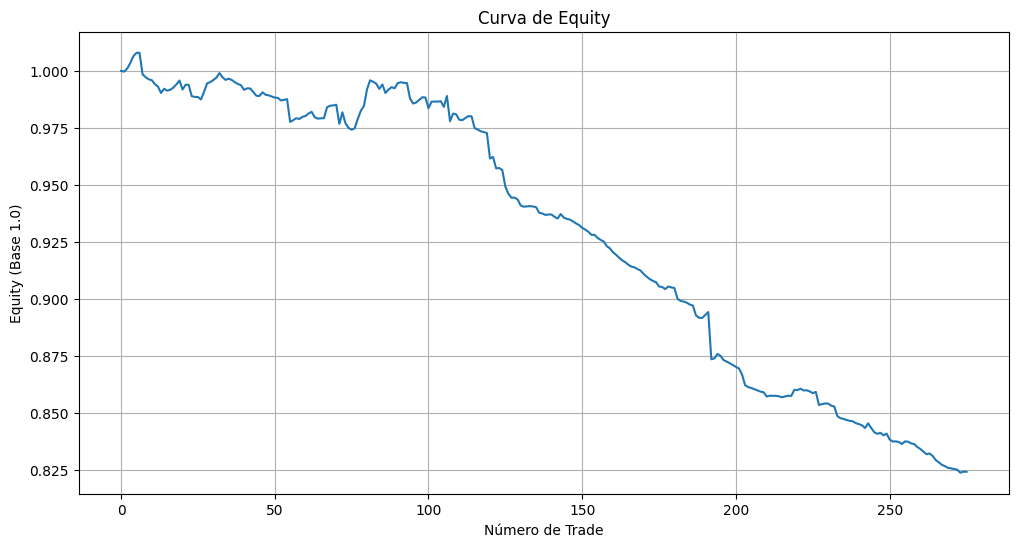

In [12]:
if len(trades) == 0:
    print('No se generaron trades con los parámetros actuales.')
else:
    results = pd.DataFrame([t.__dict__ for t in trades])
    
    # Métricas básicas
    tot_ret = (1 + results['ret']).prod() - 1
    win_rate = (results['ret'] > 0).mean()
    avg_ret = results['ret'].mean()
    avg_bars = results['bars'].mean()
    
    # Curva de equity
    equity = [1.0]
    for r in results['ret']:
        equity.append(equity[-1] * (1 + r))
    equity_series = pd.Series(equity)
    
    # Drawdown
    roll_max = equity_series.cummax()
    drawdown = (equity_series - roll_max) / roll_max
    max_dd = drawdown.min()
    
    # Métricas adicionales
    total_bars = results['bars'].sum()
    best_trade = results['ret'].max()
    worst_trade = results['ret'].min()
    
    print(f"=== MÉTRICAS DE LA ESTRATEGIA ===")
    print(f"Total de trades: {len(results)}")
    print(f"Retorno total: {tot_ret:.2%}")
    print(f"Win rate: {win_rate:.2%}")
    print(f"Retorno medio por trade: {avg_ret:.2%}")
    print(f"Duración media por trade: {avg_bars:.1f} barras (~{avg_bars/60:.1f} horas)")
    print(f"Mejor trade: {best_trade:.2%}")
    print(f"Peor trade: {worst_trade:.2%}")
    print(f"Max Drawdown: {max_dd:.2%}")
    print(f"\n=== PRIMEROS 10 TRADES ===")
    print(results.head(10))
    
    # Gráfico simple de equity curve
    import matplotlib.pyplot as plt
    
    plt.figure(figsize=(12, 6))
    plt.plot(equity_series)
    plt.title('Curva de Equity')
    plt.xlabel('Número de Trade')
    plt.ylabel('Equity (Base 1.0)')
    plt.grid(True)
    plt.show()

## Análisis adicional de trades

In [13]:
if len(trades) > 0:
    # Análisis por año
    results['year'] = results['entry_date'].dt.year
    yearly_perf = results.groupby('year')['ret'].apply(lambda x: (1 + x).prod() - 1)
    yearly_count = results.groupby('year').size()
    
    print("\n=== DESEMPEÑO POR AÑO ===")
    for year in yearly_perf.index:
        print(f"Año {year}: {yearly_perf[year]:.2%} ({yearly_count[year]} trades)")
    
    # Razón de salida
    results['exit_reason'] = 'Tiempo'
    for i, trade in results.iterrows():
        idx = trade.name
        if trades[idx].ret > 0:
            results.loc[idx, 'exit_reason'] = 'RSI/BBM'
    
    exit_reasons = results['exit_reason'].value_counts()
    print(f"\n=== RAZÓN DE SALIDA ===")
    for reason, count in exit_reasons.items():
        print(f"{reason}: {count} trades ({count/len(results):.1%})")


=== DESEMPEÑO POR AÑO ===
Año 2018: 0.79% (5 trades)
Año 2019: -1.92% (19 trades)
Año 2020: -0.66% (38 trades)
Año 2021: 0.42% (34 trades)
Año 2022: -1.28% (21 trades)
Año 2023: -7.81% (68 trades)
Año 2024: -4.46% (32 trades)
Año 2025: -3.89% (58 trades)

=== RAZÓN DE SALIDA ===
Tiempo: 189 trades (68.7%)
RSI/BBM: 86 trades (31.3%)
